In [11]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

%pip install networkx ply cirq

import sys
sys.meta_path[:] = [f for f in sys.meta_path if "DaskFinder" not in str(f)]

import cirq
import networkx as nx
import random as rand
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import numpy.random as npr

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


to build genome, we're looking to make a function that can convert a function with a defined mutation function $\mu$ that maps from a type genome to genome, should i create a class? nah bad idea no reason to deal with that lmao. then we use a fitness function $\nu$

lol i made a class

$\mu: G \mapsto G$: what am i supposed to d here lma
uhhhh, make a

In [12]:
# hyper parameters

MUT_CHANCE = 0.2
EXPLORE = 0.2 # chance to add new gate

GATES = ["H", "Rx", "Ry", "Rz", "CNOT", "RZZ"]

In [13]:
import cirq
import numpy as np
from scipy.stats import norm

def compute_bell_curve_proximity(
    state_vector, 
    normalized_bell_mean: float = 0.5,  # Now an input in [0,1]
    normalized_bell_std: float = 0.5,   # Now an input in [0,1]
    num_shots: int = 1000
) -> dict:
    """
    Compute the proximity of a quantum circuit's generated states to a Bell curve distribution.
    The inputs normalized_bell_mean and normalized_bell_std are now within [0,1], where:
    - 0 corresponds to the first histogram bin, and 1 to the last bin.
    - Standard deviation of 0 means minimal spread, 1 means full histogram range.
    """

    def safe_log(x):
        return np.log(x + 1e-10)

    # Simulate the circuit
    probabilities = np.abs(state_vector) ** 2
    basis_indices = np.arange(len(probabilities))

    # Sample measurements
    measurement_results = np.random.choice(basis_indices, size=num_shots, p=probabilities)

    # Compute histogram bins for scaling
    quantum_hist, bin_edges = np.histogram(measurement_results, bins='auto', density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  

    # Define bin range
    min_bin, max_bin = bin_centers[0], bin_centers[-1]

    # Reverse map the inputs to real values
    bell_mean = min_bin + (normalized_bell_mean * (max_bin - min_bin))
    bell_std = normalized_bell_std * (max_bin - min_bin)  # Scale std to range

    # Generate reference Bell curve using interpreted values
    bell_curve_samples = np.random.normal(
        loc=bell_mean, 
        scale=bell_std, 
        size=num_shots
    )

    # Compute histograms
    bell_hist, _ = np.histogram(bell_curve_samples, bins=bin_edges, density=True)

    # Avoid division by zero
    quantum_hist += 1e-10
    bell_hist += 1e-10

    # Normalize histograms
    quantum_hist /= np.sum(quantum_hist)
    bell_hist /= np.sum(bell_hist)

    # KL Divergence
    kl_divergence = np.sum(quantum_hist * safe_log(quantum_hist / bell_hist))

    # Jensen-Shannon Divergence
    m_hist = 0.5 * (quantum_hist + bell_hist)
    js_divergence = 0.5 * (
        np.sum(quantum_hist * safe_log(quantum_hist / m_hist)) +
        np.sum(bell_hist * safe_log(bell_hist / m_hist))
    )

    # Wasserstein Distance
    from scipy.stats import wasserstein_distance
    ws_distance = wasserstein_distance(measurement_results, bell_curve_samples)

    # Bell Curve Alignment Score
    bell_curve_alignment_score = 1 / (1 + kl_divergence)

    return {
        'bell_mean': bell_mean,  # Now in real range
        'bell_std': bell_std,    # Now in real range
        'kl_divergence': kl_divergence,
        'js_divergence': js_divergence,
        'wasserstein_distance': ws_distance,
        'bell_curve_alignment_score': bell_curve_alignment_score
    }
    
from typing import List, Optional, Union

def meyer_wallach_measure(state_vector) -> float:
    """
    Calculate the Meyer-Wallach entanglement measure for a quantum circuit.

    The Meyer-Wallach measure is a global entanglement measure that ranges from 0
    (no entanglement) to 1 (maximal entanglement).

    Args:
        circuit: The cirq.circuits.circuit.Circuit to analyze
        initial_state: Optional initial state vector. If None, |0...0⟩ is used.

    Returns:
        float: The Meyer-Wallach entanglement measure (between 0 and 1)
    """

    import math as m
    
    n_qubits = m.floor(m.log2(state_vector.shape[0]))

    if n_qubits == 0:
        return 0.0

    # Calculate the Meyer-Wallach measure
    mw_sum = 0.0

    for k in range(n_qubits):
        # Calculate the reduced density matrix for qubit k
        rho_k = reduced_density_matrix(state_vector, k, n_qubits)

        # Calculate the purity of the reduced density matrix
        purity = np.trace(rho_k @ rho_k).real

        # Add to the sum
        mw_sum += (1 - purity)

    # Normalize by the number of qubits
    meyer_wallach = mw_sum / n_qubits

    return meyer_wallach


def reduced_density_matrix(state_vector: np.ndarray,
                           qubit_index: int,
                           n_qubits: int) -> np.ndarray:
    """
    Calculate the reduced density matrix for a specific qubit.

    Args:
        state_vector: The state vector of the full system
        qubit_index: The index of the qubit to calculate the reduced density matrix for
        n_qubits: Total number of qubits in the system

    Returns:
        np.ndarray: The 2x2 reduced density matrix for the specified qubit
    """
    # Initialize the reduced density matrix
    rho = np.zeros((2, 2), dtype=complex)

    # Reshape the state vector as a multi-qubit state
    state_tensor = state_vector.reshape([2] * n_qubits)

    # Calculate the reduced density matrix elements
    for i in range(2):
        for j in range(2):
            # Create slice objects for the target qubit
            i_slice = slice(i, i+1)
            j_slice = slice(j, j+1)

            # Create a list of slice objects for all qubits
            slices_i = [slice(None)] * n_qubits
            slices_j = [slice(None)] * n_qubits

            # Set the slice for the target qubit
            slices_i[qubit_index] = i_slice
            slices_j[qubit_index] = j_slice

            # Calculate the reduced density matrix element
            if i == j:
                # Diagonal element
                rho[i, j] = np.sum(np.abs(state_tensor[tuple(slices_i)])**2)
            else:
                # Off-diagonal element
                state_i = state_tensor[tuple(slices_i)]
                state_j = state_tensor[tuple(slices_j)]

                # Calculate the overlap
                for idx in np.ndindex(state_i.shape):
                    idx_i = list(idx)
                    idx_j = list(idx)

                    # Set the slices for the full index
                    full_idx_i = tuple(idx_i)
                    full_idx_j = tuple(idx_j)

                    # Calculate the contribution to the off-diagonal element
                    rho[i, j] += np.conj(state_i[full_idx_i]) * state_j[full_idx_j]

    return rho

from scipy.stats import norm
from scipy.optimize import minimize_scalar

def skewed_normal(x, s, mu, sigma=1.0):
    # Avoid endpoints (x = 0 or 1) to prevent division by zero
    x = np.clip(x, 1e-10, 1 - 1e-10)
    z = np.log(x/(1-x)) - mu
    # Use the scaled normal pdf and CDF:
    pdf = 1.0/(sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*(z/sigma)**2)
    cdf = norm.cdf(s*(z/sigma))
    return (2.0 / (x*(1-x))) * pdf * cdf

def find_mode_brent(s, mu, sigma):
    res = minimize_scalar(lambda x: -skewed_normal(x, s, mu, sigma),
                          bounds=(1e-10, 1-1e-10),
                          method='bounded')
    mode = res.x # type: ignore
    max_val = skewed_normal(mode, s, mu, sigma)
    return mode, max_val

def normalized_skewed(x, s, mu, sigma):
    mode, max_val = find_mode_brent(s, mu, sigma)
    return skewed_normal(x, s, mu, sigma) / max_val

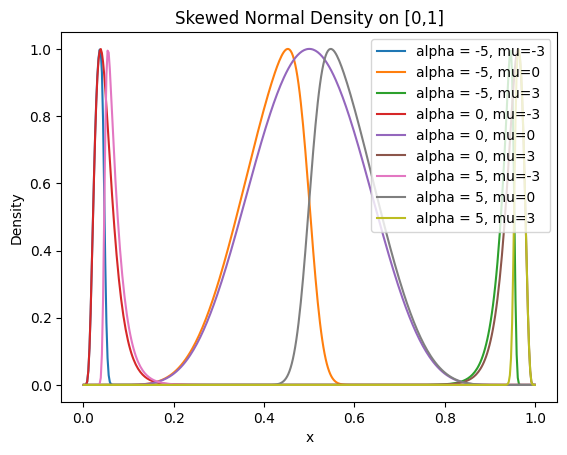

In [14]:
import matplotlib.pyplot as plt

xs = np.linspace(0.001, 0.999, 400)
for s in [-5, 0, 5]:
    for mu in [-3, 0, 3]:
        plt.plot(xs, normalized_skewed(xs, s, mu, 0.5), label=f'alpha = {s}, mu={mu}')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Skewed Normal Density on [0,1]')
plt.legend()
plt.show()

In [15]:
import cirq.devices.line_qubit
import cirq.circuits.circuit
import cirq.ops.common_gates
import cirq.study.sweeps
import cirq.sim.sparse_simulator

qubits = cirq.devices.line_qubit.LineQubit.range(3)
X = [sp.Symbol(f'x_{i}') for i in range(3)]
circuit = cirq.circuits.circuit.Circuit(
    *[cirq.ops.common_gates.H(qubit) for qubit in qubits],
    *[cirq.ops.common_gates.Rx(rads=X[i])(qubits[i]) for i in range(len(qubits))]
)

sweeps = [cirq.study.sweeps.Linspace(f"x_{i}", 0, 2 * np.pi, 6) for i in range(len(X))]
t_sweep = sweeps.pop()
while len(sweeps) > 0:
    t_sweep = t_sweep * sweeps.pop()

sim = cirq.sim.sparse_simulator.Simulator()
results = sim.simulate_sweep(circuit, params=t_sweep)

In [16]:
type(results[0].final_state_vector)
compute_bell_curve_proximity(results[0].final_state_vector)

{'bell_mean': 3.5,
 'bell_std': 3.2083333333333335,
 'kl_divergence': 0.4352963854796546,
 'js_divergence': 0.14009895198952396,
 'wasserstein_distance': 0.8262848490706817,
 'bell_curve_alignment_score': 0.6967202106245219}

In [17]:
import cirq.ops.measure_util
import cirq.ops.common_gates
import cirq.circuits.circuit
import cirq.devices.line_qubit
import cirq.ops.parity_gates
import cirq.sim.sparse_simulator
import cirq.study.sweeps

class Gate:
    def __init__(self, gate, qubits, parameter):
        """
        :param gate: enum, [H, Rx, Ry, Rz, CNOT, RZZ]
        :param qubits: tuple (i_0: int,) for gate on qubits i
        :param parameter: p: int U None, parameter to gate given by \theta_p
        :returns None
        """

        self.gates = gate
        self.qubits = qubits
        self.parameter = parameter

    def __str__(self):
        return f"Gate({GATES[self.gates]}, {self.qubits}, {self.parameter})"

    def __copy__(self):
        return Gate(self.gates, self.qubits, self.parameter)

    def __eq__(self, other):
        return id(self) == id(self)

class Gene:
    def __init__(self, gates, n, p: int = 0):
        """
        :param gates: Array[Gate] gates in the genome
        :param n: amount of qubits
        :param p: highest number of parameters in the circuit (max param)
        """
        self.gates = gates
        self.n = n

        # find max index parameter in gates
        self.p = max([gate.parameter for gate in gates]) if len(gates) > 0 else 0

    def add_gate(self, g):
        self.gates.append(g)
        self.p = max([gate.parameter for gate in self.gates])

    def to_circuit(self):
        c = cirq.circuits.circuit.Circuit()
        qubits = cirq.devices.line_qubit.LineQubit.range(self.n)
        X = [sp.Symbol(f'x_{i}') for i in range(self.p + 1)]
        
        for qubit in qubits: c.append(cirq.ops.common_gates.Rx(rads=0)(qubit))
        
        for gate in self.gates:
            qs = [qubits[q] for q in gate.qubits]
            match gate.gates:
                case 0:
                    c.append(cirq.ops.common_gates.H(*qs))
                case 1:
                    c.append(cirq.ops.common_gates.Rx(rads=X[gate.parameter])(*qs))
                case 2:
                    c.append(cirq.ops.common_gates.Ry(rads=X[gate.parameter])(*qs))
                case 3:
                    c.append(cirq.ops.common_gates.Rz(rads=X[gate.parameter])(*qs))
                case 4:
                    c.append(cirq.ops.common_gates.CNOT(*qs))
                case 5:
                    c.append(cirq.ops.parity_gates.ZZ(*qs) ** X[gate.parameter])

        c.append(cirq.ops.measure_util.measure(*qubits, key='x'))

        return c, X

    def evaluate(self, W = [1e3, 1e3, 1e1, 1e1, 1e1, 1e4], P=[0.5, 0.5, 0, 0, 0.5, 0, 0, 0.5], samples=6, o=False) -> int:
        # P:[mean, std, \alpha_0, \mu_0, \sigma_0, \alpha_1, \mu_1, \sigma_1]
        # \alpha \in [-5, 5], \mu \in [-3, 3], \sigma \in [0, 1]
        
        two_qubits = sum([1 if gate.gates > 3 else 0 for gate in self.gates])
        
        circuit, X = self.to_circuit()
        circuit = circuit[:-1]
        
        if len(circuit) == 0:
            return 0
        
        sweeps = [cirq.study.sweeps.Linspace(f"x_{i}", 0, 2 * np.pi, samples) for i in range(len(X))]
        t_sweep = sweeps.pop()
        while len(sweeps) > 0:
            t_sweep = t_sweep * sweeps.pop()

        sim = cirq.sim.sparse_simulator.Simulator()
        results = sim.simulate_sweep(circuit, params=t_sweep)
    
        divergence = []
        mw_term = []
        
        for result in results:
            if result.final_state_vector.shape[0] != 2**self.n:
                raise ValueError(f"State vector dimension {result.final_state_vector.shape[0]} does not match 2^{n_qubits}") # type: ignore
            
            divergence.append(compute_bell_curve_proximity(result.final_state_vector, P[0], P[1])['bell_curve_alignment_score'])

            mw_term.append(meyer_wallach_measure(result.final_state_vector))

        divergence = sum(divergence) / len(divergence)
        mw_term = sum(mw_term) / len(mw_term)
            
        all_qubits = set(circuit.all_qubits())  # Get all qubits in the circuit
        used_qubits = set() 

        for moment in circuit[1:]:
            for op in moment.operations:
                used_qubits.update(op.qubits)

        if o: print(f'kl-divergence: {divergence} -> {1.25 * normalized_skewed(divergence, P[2], P[3], P[4]) - 0.25}, mw measure: {mw_term} -> {1.25 * normalized_skewed(mw_term, P[5], P[6], P[7]) -0.25}, depth: {len(circuit)} -> {1 / len(circuit)}, unused qubits: {len(all_qubits - used_qubits)}')

        return  W[0] * (1.25 * normalized_skewed(divergence, P[2], P[3], P[4]) - 0.25) + W[1] * (1.25 * normalized_skewed(mw_term, P[5], P[6], P[7]) - 0.25) + W[2] * (1 / len(circuit)) + W[3] * (1/(abs(self.p - 2) + 1)) + W[4] * (1/(1 + two_qubits)) - W[5] * (len(all_qubits - used_qubits))

    def mutate(self): # \mu
        # make a copy to be the next version of this agent
        fut = self.__copy__()
        
        
        
        def num_g(x, n, m):
            import math
            
            return math.floor(n * normalized_skewed(x, 0, 0.5, m) + 0.5)

        if npr.choice([True, False], p=[MUT_CHANCE, 1-MUT_CHANCE]):
            # select "gene" to mutate
            if npr.choice([True, False], p=[EXPLORE, 1-EXPLORE]):
                for i in range(num_g(rand.random(), len(self.gates), 0.2)): # add gates based on shifted sigmoid

                    gate = rand.randint(0, 5)
                    open_qubits = list(range(self.n))
                    q1 = open_qubits.pop(npr.choice(open_qubits))
                    q2 = npr.choice(open_qubits) if gate >= 3 else None

                    qubits = (q1, q2) if gate >= 4 else (q1,)

                    # give it a EXPLORE ** 2 to add a new parameter yk
                    parameter = rand.randint(0, fut.p) if npr.choice([False, True], p=[EXPLORE, 1 - (EXPLORE)]) else fut.p + 1

                    fut.add_gate(Gate(
                        gate,
                        qubits,
                        parameter
                    ))
            else:
                nchange = num_g(rand.random(), len(self.gates) // 3, 0.2) # up to third of gates can be changed

                for _ in range(nchange):
                    gate = npr.choice(self.gates)

                    if npr.choice([False, True], p = [EXPLORE, 1-EXPLORE]):
                        gate.gates = rand.randint(0, 3) if gate.gates <= 3 else rand.randint(4, 5)
                        gate.parameter = rand.randint(0, fut.p) if npr.choice([False, True], p=[EXPLORE * 2, 1 - (EXPLORE * 2)]) else fut.p + 1
                    else:
                        self.gates.remove(gate) # womp womp get cooketh

        return fut.__copy__()

    def __str__(self):
        return f'Gene({", ".join([gate.__str__() for gate in self.gates])})'

    def __copy__(self):
        return Gene([g.__copy__() for g in self.gates], self.n, self.p) 

In [19]:
# optimize \nu in \mathbb{P}
from scipy.optimize import minimize

ansatz_list = [
    Gene([
        *[Gate(2, (n,), n) for n in range(3)],  # R_y on each qubit
        *[Gate(4, (n, (n + 1) % 3), 0) for n in range(3)],  # CNOT in a circular pattern
        *[Gate(2, (n,), n + 3) for n in range(3)],  # Another R_y layer
        *[Gate(4, ((n + 1) % 3, (n + 2) % 3), 0) for n in range(3)]  # Shifted CNOT pattern
    ], 3),  # HEA

    Gene([
        *[Gate(2, (n,), n) for n in range(3)],  # R_y initial rotations
        *[Gate(4, (n, (n + 1) % 3), 0) for n in range(3)],  # CNOT layer
        *[Gate(1, (n,), n + 3) for n in range(3)],  # R_x rotations
        *[Gate(4, ((n + 2) % 3, (n + 3) % 3), 0) for n in range(3)]  # Another entangling layer
    ], 3),  # UCCSD

    Gene([
        *[Gate(2, (n,), n) for n in range(3)],  # R_y rotations
        *[Gate(4, (n, (n + 1) % 3), 0) for n in range(3)],  # Linear entanglement CNOTs
        *[Gate(1, (n,), n + 3) for n in range(3)],  # R_x layer
        *[Gate(4, ((n + 2) % 3, (n + 3) % 3), 0) for n in range(3)]  # Shifted CNOTs
    ], 3),  # Alternating Layer Ansatz

    Gene([
        *[Gate(1 if n % 2 == 0 else 2, (n,), n) for n in range(3)],  # Alternating Rx, Ry
        *[Gate(4, (n, n + 1), 0) for n in range(0, 3, 2)],  # First entangling layer
        *[Gate(1 if n % 2 == 1 else 2, (n,), n + 3) for n in range(3)],  # Alternating Rx, Ry
        *[Gate(4, (n, n + 1), 0) for n in range(1, 3, 2)]  # Second entangling layer
    ], 3),  # Brickwork Ansatz

    Gene([
        *[Gate(1, (n,), n) for n in range(3)],  # R_x rotations
        *[Gate(2, (n,), n + 3) for n in range(3)],  # R_y rotations
        *[Gate(3, (n,), n + 6) for n in range(3)],  # R_z rotations
        *[Gate(4, (n, (n + 1) % 3), 0) for n in range(3)],  # Full CNOT connectivity
    ], 3),  # Strongly Entangled Ansatz

    Gene([
        *[Gate(2, (n,), n) for n in range(3)],  # R_y rotations
        *[Gate(4, (n, (n + 1) % 3), 0) for n in range(3)],  # Circular CNOTs
        *[Gate(2, (n,), n + 3) for n in range(3)],  # Another R_y layer
    ], 3),  # Circular Ansatz

    Gene([
        *[Gate(2, (n,), n) for n in range(3)],  # R_y rotations
        *[Gate(4, (n, n + 1), 0) for n in range(0, 2, 2)],  # First CNOT layer
        *[Gate(2, (n,), n + 3) for n in range(3)],  # Another R_y layer
        *[Gate(4, (n, n + 1), 0) for n in range(1, 3, 2)],  # Second CNOT layer
    ], 3),  # Ladder Ansatz

    Gene([
        *[Gate(2, (n,), n) for n in range(3)],  # R_y initial rotations
        *[Gate(4, (n, (n + 1) % 3), 0) for n in range(0, 3, 2)],  # SWAP pattern 1
        *[Gate(2, (n,), n + 3) for n in range(3)],  # Another R_y layer
        *[Gate(4, (n, (n + 1) % 3), 0) for n in range(1, 3, 2)],  # SWAP pattern 2
    ], 3),  # Givens Ansatz
]

def simple_callback(xk):
    print(f"current solution is: {xk}")

def evaluate_cost(X):
    """
    Evaluates cost as sum of all difference from max possible score of all ansatz / amount of ansatz
    
    Used to optimize optimal maps for expressibility and entanglement
    
    P; list: [\\alpha_0, \\mu_0, \\sigma_0] x2
    """
    
    print(f"for {X}")
    scores = []
    for idx, gene in enumerate(ansatz_list):
        scores.append(-gene.evaluate(W=[1, 1, 0, 0, 0, 0], P=[0.5, 0.5, *X], samples=3))
        print(f"tested ansatz {idx} with score {scores[-1]}")
    print("-" * 20)
    return sum(scores) / len(scores)

from scipy.optimize import minimize

print("-" * 20)
optimized = minimize(fun=evaluate_cost,
                     x0=[0, 0, 0.5, 0, 0, 0.5],
                     #x0 = [10 * rand.random() - 5, 6 * rand.random() - 3, 0.5 * rand.random(), 10 * rand.random() - 5, 6 * rand.random() - 3, 0.5 * rand.random()],
                     bounds=[(-5, 5), (-3, 3), (0, 0.5), (-5, 5), (-3, 3), (0, 0.5)],
                     method="Nelder-Mead",
                     options={ 'disp': True },
                     callback=simple_callback)

--------------------
for [0.  0.  0.5 0.  0.  0.5]
tested ansatz 0 with score 0.5
tested ansatz 1 with score 0.5
tested ansatz 2 with score 0.5


IndexError: list index out of range

In [20]:
ansatz_list[3].evaluate(W=[1, 1, 0, 0, 0, 0], P=[0.5, 0.5, 5, 3, 0.8, -5, -3, 0.8], samples=3, o=True)

IndexError: list index out of range

In [21]:
normalized_skewed(1, 5, 3, 0.8)

2.9322307078639274e-128

In [22]:
optimized

NameError: name 'optimized' is not defined

## testing out classes

In [23]:
test = Gene([
    Gate(2, (0,), 0),
    Gate(0, (1,), 0),
    Gate(0, (2,), 0),
    Gate(4, (0, 1,), 0)
], 3)
test.evaluate(o=True)

kl-divergence: 0.5402607908122278 -> 0.9442916634663652, mw measure: 2.031470419044328e-08 -> -0.25, depth: 3 -> 0.3333333333333333, unused qubits: 0


705.958330133032

In [24]:
test.to_circuit()

(0: ───Rx(0)───Ry(x_0)───@───M('x')───
                        │   │
1: ───Rx(0)───H─────────X───M────────
                            │
2: ───Rx(0)───H─────────────M────────,
 [x_0])

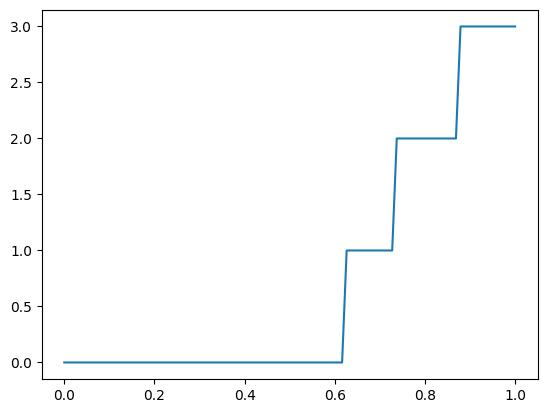

In [25]:
def num_g(r, n = 3, s=2):
    import math as m

    sigmoid = lambda x: 1 / (1 + m.exp(-x))
    return m.floor((n + 0.5) * sigmoid(s * m.e * (r - ((0.25) ** (1/s)))))

# generate a plot for num_g
x = np.linspace(0, 1, 100)
y = [num_g(i, s=4) for i in x]
plt.plot(x, y)
plt.show()

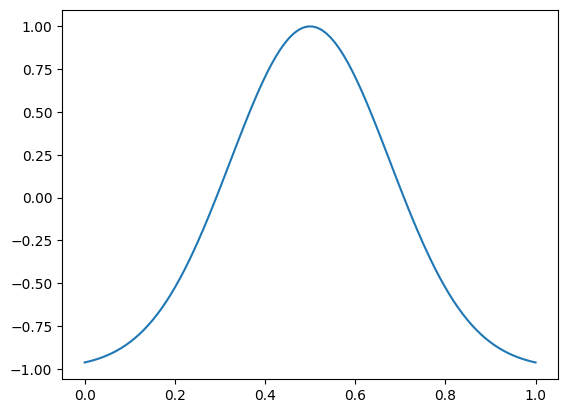

In [26]:
def mw_map(x):
    import math as m
    return 2 * m.exp(-(4 * (x - 0.5))**2) - 1

x = np.linspace(0, 1, 100)
y = [mw_map(i) for i in x]
plt.plot(x, y)
plt.show()

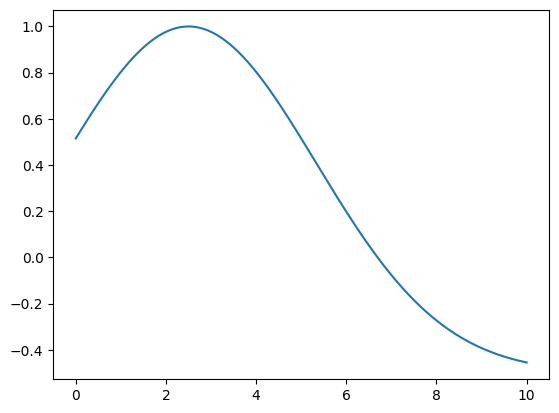

In [27]:
def depth_map(x):
    import math as m
    return 1.5 * m.exp(-(0.25 * (x - 2.5)) ** 2) - 0.5

x = np.linspace(0, 10, 1000)
y = [depth_map(i) for i in x]
plt.plot(x, y)
plt.show()

In [30]:
mutated = test.mutate()
while len(mutated.gates) == len(test.gates):
    mutated = test.mutate()

mutated.to_circuit()

(0: ───Rx(0)───Ry(x_0)───@─────────Rx(x_0)───ZZ───────X───M('x')───
                        │                   │        │   │
1: ───Rx(0)───H─────────X───────────────────┼────────@───M────────
                                            │            │
2: ───Rx(0)───H─────────Rz(x_1)─────────────ZZ^x_1───────M────────,
 [x_0, x_1])

In [31]:
for _ in range(10):
    X = [0.1 * np.pi for _ in range(mutated.p + 1)]
    print(f"fitness: {mutated.evaluate(X)} for {mutated}")
    mutated = mutated.mutate()

IndexError: list index out of range

In [32]:
mutated.to_circuit()

(0: ───Rx(0)───Ry(x_0)───@─────────Rx(x_0)───ZZ───────X───M('x')───
                        │                   │        │   │
1: ───Rx(0)───H─────────X───────────────────┼────────@───M────────
                                            │            │
2: ───Rx(0)───H─────────Rz(x_1)─────────────ZZ^x_1───────M────────,
 [x_0, x_1])

oka let's give it a shot

## basic genetic algorithm implementation

In [33]:
# new hyperparameters
GEN_SIZE = 100
EPOCHS = 15
QUBITS = 4

PERCENTAGE = 0.2 # gen size should be divisible by percentage bc

def num_g(r, n = 3, s=2):
    import math as m

    sigmoid = lambda x: 1 / (1 + m.exp(-x))
    return m.floor((n + 0.5) * sigmoid(s * m.e * (r - ((0.25) ** (1/s)))))

In [34]:
current_generation = []
for _ in range(GEN_SIZE):
    g = Gene([], QUBITS)

    for _ in range(num_g(rand.random(), QUBITS // 2, s=4)):
        gate = rand.randint(0, 5)
        open_qubits = list(range(QUBITS))
        q1 = open_qubits.pop(npr.choice(open_qubits))
        q2 = npr.choice(open_qubits) if gate >= 4 else None

        qubits = (q1, q2) if gate >= 4 else (q1,)

        # give it a EXPLORE ** 2 to add a new parameter yk
        parameter = rand.randint(0, g.p) if npr.choice([False, True], p=[EXPLORE ** 2, 1 - (EXPLORE ** 2)]) else g.p + 1

        g.add_gate(Gate(
            gate,
            qubits,
            parameter
        ))

    current_generation.append(g)

In [35]:
for gene in current_generation:
    print(gene) # making sure something doesn't look completely stupid here

Gene()
Gene(Gate(Rz, (3,), 0), Gate(Rz, (0,), 0))
Gene()
Gene()
Gene()
Gene()
Gene()
Gene(Gate(H, (3,), 0))
Gene()
Gene()
Gene()
Gene(Gate(CNOT, (2, 0), 0), Gate(Rx, (3,), 0))
Gene()
Gene(Gate(CNOT, (2, 3), 0))
Gene(Gate(H, (3,), 0))
Gene()
Gene(Gate(Ry, (0,), 0), Gate(CNOT, (0, 1), 0))
Gene()
Gene()
Gene()
Gene()
Gene()
Gene()
Gene(Gate(RZZ, (0, 2), 0), Gate(CNOT, (1, 2), 0))
Gene(Gate(RZZ, (3, 0), 0))
Gene()
Gene(Gate(Rx, (2,), 0), Gate(CNOT, (1, 2), 0))
Gene(Gate(Ry, (2,), 0))
Gene(Gate(RZZ, (0, 3), 0))
Gene()
Gene(Gate(Ry, (0,), 0))
Gene()
Gene()
Gene()
Gene(Gate(Rx, (0,), 0))
Gene()
Gene()
Gene(Gate(Rz, (0,), 0), Gate(H, (2,), 0))
Gene(Gate(RZZ, (0, 2), 0))
Gene(Gate(RZZ, (0, 2), 0))
Gene()
Gene()
Gene()
Gene(Gate(Rx, (1,), 0), Gate(Rx, (3,), 0))
Gene()
Gene()
Gene(Gate(Ry, (1,), 0))
Gene()
Gene()
Gene()
Gene()
Gene()
Gene()
Gene()
Gene()
Gene()
Gene()
Gene()
Gene(Gate(Ry, (1,), 0), Gate(Rx, (3,), 0))
Gene(Gate(H, (0,), 0), Gate(Ry, (0,), 0))
Gene()
Gene()
Gene()
Gene()
Gene()
Gen

In [36]:
for epoch in range(EPOCHS):
    if epoch % 2 == 0:
        print(f"Epoch {epoch}:")
        print(f"==============")

    total_fitness = []
    for ngene in range(len(current_generation)):
        total_fitness.append(current_generation[ngene].evaluate())
        if ngene % (GEN_SIZE // 5) == 0 and epoch % 2 == 0:
            print(f'calculated fitness for gene {ngene}.')

    combined_array = zip(current_generation, total_fitness)
    sorted_array = sorted(combined_array, key=lambda x: x[1])

    if epoch % 2 == 0:
        print(f"Max fitness is: ({sorted_array[-1][0]}, {sorted_array[-1][1]})")
        best = sorted_array[-1][0]
        best_performance = sorted_array[-1][1]

    # select PERCENTAGE% of current_generation with highest fitness
    selected = [x[0] for x in sorted_array[int(-PERCENTAGE* GEN_SIZE):]]

    current_generation.clear() # yay

    for gene in selected: # aw :(
        for _ in range(int(GEN_SIZE / (PERCENTAGE * 100))):
            current_generation.append(gene.mutate())

Epoch 0:
calculated fitness for gene 0.
calculated fitness for gene 20.
calculated fitness for gene 40.
calculated fitness for gene 60.
calculated fitness for gene 80.
Max fitness is: (Gene(Gate(RZZ, (1, 3), 0), Gate(CNOT, (2, 0), 0)), -488.33333333333337)
Epoch 2:
calculated fitness for gene 0.
calculated fitness for gene 20.
calculated fitness for gene 40.
calculated fitness for gene 60.
calculated fitness for gene 80.
Max fitness is: (Gene(Gate(RZZ, (1, 3), 0), Gate(CNOT, (2, 0), 0)), -488.33333333333337)
Epoch 4:
calculated fitness for gene 0.
calculated fitness for gene 20.
calculated fitness for gene 40.
calculated fitness for gene 60.
calculated fitness for gene 80.
Max fitness is: (Gene(Gate(RZZ, (1, 3), 0), Gate(CNOT, (2, 0), 0), Gate(Ry, (3,), 0)), 713.0562592273751)
Epoch 6:
calculated fitness for gene 0.
calculated fitness for gene 20.
calculated fitness for gene 40.
calculated fitness for gene 60.
calculated fitness for gene 80.
Max fitness is: (Gene(Gate(RZZ, (1, 3), 0), 

kl-divergence: 0.537289906427667 -> 0.9520859404674635, mw measure: -1.3019490041621395e-08 -> -0.25, depth: 3 -> 0.3333333333333333, unused qubits: 0
712.0859404674636


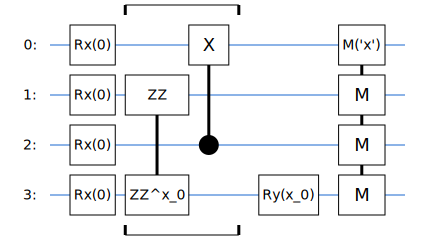

In [37]:
from cirq.contrib.svg.svg import SVGCircuit, circuit_to_svg
import cirq.study.resolver

C, params = best.to_circuit()
resolver = cirq.study.resolver.ParamResolver({params[i]: 0.5 * np.pi for i in range(len(params))})

print(best.evaluate(o=True))

SVGCircuit(C)

## testing part two

In [38]:
test = Gene([
    Gate(0, (0,), 0),
    *[Gate(4, (0, i+1), 0) for i in range(3)]
], 4)

In [39]:
from cirq.contrib.svg.svg import SVGCircuit, circuit_to_svg
import cirq.sim.sparse_simulator
import cirq.study.resolver

scores = []

for x in range(0, 200):
    X = [(x / 100) * np.pi for _ in range(test.p + 1)]
    
    c, params = test.to_circuit()
    c = c[1:]
    resolver = cirq.study.resolver.ParamResolver({params[i]: X[i] for i in range(len(X))})

    sim = cirq.sim.sparse_simulator.Simulator()
    results = sim.simulate(c[:-1], param_resolver=resolver)

    r = compute_bell_curve_proximity(results.final_state_vector, 0.5, 0.5)
    scores.append(r['bell_curve_alignment_score'])

scores

[0.34940142317968903,
 0.3336975740478507,
 0.34554795379835135,
 0.3148112404818228,
 0.3167708370809525,
 0.3324687927286722,
 0.33641104432495816,
 0.33437779166537396,
 0.33671568471343527,
 0.3286513863015118,
 0.33627737159921123,
 0.335682791036362,
 0.318233626936005,
 0.3204924392588577,
 0.33652061442434894,
 0.3339766913624852,
 0.3227195866831622,
 0.33635814730059876,
 0.3339988961281366,
 0.3335436855199177,
 0.33809207128837915,
 0.32777309763920726,
 0.3178056837349484,
 0.3370468720603579,
 0.32335516599269126,
 0.33112235724930195,
 0.33059897372376595,
 0.33915703385732254,
 0.3249863367746188,
 0.3170401559949488,
 0.3210948163888039,
 0.33612384315168675,
 0.31163078319357757,
 0.34864659280027355,
 0.3450600098038182,
 0.33763374595535195,
 0.35025811050043093,
 0.34068885128870074,
 0.3200442322913083,
 0.3490406433530972,
 0.3188556656848725,
 0.33713591006415805,
 0.31481960811857895,
 0.33574959216283967,
 0.30942937216419636,
 0.3207374532250198,
 0.335868381

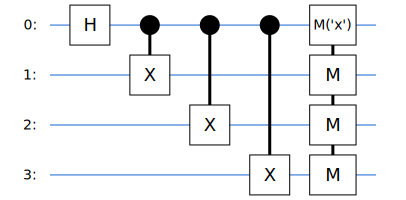

In [40]:
SVGCircuit(c)

In [41]:
test.evaluate(o=True)

kl-divergence: 0.3377068462803039 -> 0.3139372462959179, mw measure: 0.500000059604643 -> 0.9999999999998757, depth: 5 -> 0.2, unused qubits: 0


1321.7705796291268

## overall weight particle swarm optimizer

In [ ]:
%pip install cirq openfermion openfermionpyscf pyscf matplotlib qiskit qiskit-nature

import openfermion
import cirq_google
from openfermion.transforms.opconversions.conversions import get_fermion_operator
from openfermion.transforms.opconversions.jordan_wigner import jordan_wigner
from openfermion.linalg.sparse_tools import get_sparse_operator
from openfermionpyscf import run_pyscf

from scipy.optimize import minimize, dual_annealing

  error: subprocess-exited-with-error
  
  × Building wheel for pyscf (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [76 lines of output]
      C:\Users\advay\AppData\Local\Temp\pip-build-env-z8_kunha\overlay\Lib\site-packages\setuptools\config\_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
      !!
      
              ********************************************************************************
              Please use a simple string containing a SPDX expression for `project.license`. You can also use `project.license-files`. (Both options available on setuptools>=77.0.0).
      
              By 2026-Feb-18, you need to update your project and remove deprecated calls
              or your builds will no longer be supported.
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
              ***************************************************

  Using cached openfermion-1.7.0-py3-none-any.whl.metadata (13 kB)
  Using cached openfermionpyscf-0.5-py3-none-any.whl.metadata (6.9 kB)
  Using cached pyscf-2.9.0.tar.gz (10.1 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached qiskit-2.0.2-cp39-abi3-win_amd64.whl.metadata (12 kB)
  Using cached qiskit_nature-0.7.2-py3-none-any.whl.metadata (8.0 kB)
  Using cached deprecation-2.1.0-py2.py3-none-any.whl.metadata (4.6 kB)
  Using cached h5py-3.13.0-cp312-cp312-win_amd64.whl.metadata (2.5 kB)
  Using cached pubchempy-1.0.4-py3-none-any.whl
  Using cached pytest-8.4.0-py3-none-any.whl.metadata (7.7 kB)
  Using cached stevedore-5.4.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached qiskit_algorit

ModuleNotFoundError: No module named 'openfermion.utils'

In [ ]:
# hyperparameters
W_bounds = [(1e-1, 1e4), (1e-1, 1e4), (1e-1, 1e2), (1e0, 1e2), (1e-1, 1e3)]
inertia = 0.85 # weight
phi_p = 1
phi_g = 1

MUT_CHANCE = 0.2
EXPLORE = 0.2 # chance to add new gate
CROSS_CHANCE = 0.2

GATES = ["H", "Rx", "Ry", "Rz", "CNOT", "RZZ"]

p_max = 10
particles = [] # [x: [], b: [] vec x, current; vec b, best;

estimation_iters = 5
iters = 15

rounding = 2

In [43]:
# swarm globals
swarm_max = [[], 10000000]
known_v = {}

In [44]:
import cirq.ops.pauli_gates
import cirq.devices.line_qubit
import cirq.ops.pauli_string
import cirq.protocols.resolve_parameters
import cirq.study.resolver
# import qiskit
from qiskit.quantum_info import SparsePauliOp

def compute_energy(gene, parameters, hamiltonian: SparsePauliOp, simulator):
    """
    Compute the energy expectation value of the state prepared by the ansatz circuit.
    
    Args:
        gene: An object with a method `to_circuit()` that returns a tuple (circuit, ...).
        parameters: List of parameter values to resolve the ansatz circuit.
        hamiltonian: A Qiskit Hamiltonian (SparsePauliOp) after Jordan-Wigner transform.
        simulator: A cirq Simulator or a simulator that supports expectation value calculations.
        
    Returns:
        energy: The energy expectation value (a float).
    """
    # Get the ansatz circuit from the gene object.
    # If gene.to_circuit() returns (circuit, ...), we use the circuit.
    circuit, _ = gene.to_circuit()
    circuit = circuit[1:-1]
    
    # Resolve circuit parameters. Expecting parameters to match keys "x_0", "x_1", ... etc.
    resolved_circuit = cirq.protocols.resolve_parameters.resolve_parameters(
        circuit, 
        cirq.study.resolver.ParamResolver({f'x_{i}': parameters[i] for i in range(len(parameters))})
    )[0:-1]
    
    # Determine the number of qubits from the Hamiltonian.
    qubits = cirq.devices.line_qubit.LineQubit.range(hamiltonian.num_qubits)
    
    energy = 0.0
    observables = []
    coefficients = []
    
    # Loop over each term in the SparsePauliOp.
    for pauli_obj, coeff in zip(hamiltonian.paulis.to_labels(), hamiltonian.coeffs):
        label = pauli_obj.to_label()  # e.g. "IXYZ" for a 4-qubit term
        # If the term is the identity (constant term), add it directly.
        if all(ch == 'I' for ch in label):
            energy += coeff.real
            continue
        
        # Build the corresponding Cirq PauliString.
        pauli_string = None
        for idx, ch in enumerate(label):
            if ch == 'I':
                continue  # Skip identity components
            if ch == 'X':
                op = cirq.ops.pauli_gates.X(qubits[idx])
            elif ch == 'Y':
                op = cirq.ops.pauli_gates.Y(qubits[idx])
            elif ch == 'Z':
                op = cirq.ops.pauli_gates.Z(qubits[idx])
            else:
                raise ValueError(f"Unknown Pauli character: {ch}")
            # Combine into a PauliString.
            if pauli_string is None:
                pauli_string = cirq.ops.pauli_string.PauliString(op)
            else:
                pauli_string *= cirq.ops.pauli_string.PauliString(op)
                
        if pauli_string is not None:
            observables.append(pauli_string)
            coefficients.append(coeff.real)
    
    # If there are observables (non-identity terms), simulate their expectation values.
    if observables:
        expectation_values = simulator.simulate_expectation_values(
            resolved_circuit,
            observables=observables,
            param_resolver=cirq.study.resolver.ParamResolver({f'x_{i}': parameters[i] for i in range(len(parameters))})
        )
        for coef, val in zip(coefficients, expectation_values):
            energy += coef * val

    return energy

In [46]:
from qiskit_nature.settings import settings
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer, ActiveSpaceTransformer
from qiskit_nature.second_q.problems import ElectronicStructureProblem

molecule_data = {}

# Enable Qiskit Nature's second-quantization framework
settings.use_second_q = True

print('computing LiH')

# Define the LiH molecule geometry
lih_driver = PySCFDriver(atom="Li 0.0 0.0 0.0; H 0.0 0.0 1.6", basis="STO-3G")
lih_problem = lih_driver.run()

lih_active_space = ActiveSpaceTransformer(num_electrons=(2,2), num_spatial_orbitals=4)  # Modify based on results
lih_problem = lih_active_space.transform(lih_problem)

# Apply Jordan-Wigner transformation to get the qubit Hamiltonian
lih_mapper = JordanWignerMapper()
molecule_data['lih'] = {}
molecule_data['lih']['ham'] = lih_mapper.map(lih_problem.hamiltonian.second_q_op())
molecule_data['lih']['fci_energy'] = lih_problem.reference_energy

print(f'found solution in {lih_problem.num_spatial_orbitals}') 

"""
    
print('computing BH2')

# Define BH₂ molecule
bh2_driver = PySCFDriver(atom="B 0.0 0.0 0.0; H 0.0 0.0 1.2; H 0.0 1.2 0.0", basis="STO-3G", spin=1, charge=0)
bh2_problem = bh2_driver.run()

# Apply freeze-core approximation (freezing Boron 1s orbital)
bh2_transformer = ActiveSpaceTransformer(num_electrons=(2, 2), num_spatial_orbitals=4)
bh2_problem = bh2_transformer.transform(bh2_problem)

# Map to qubit Hamiltonian using Jordan-Wigner
jw_mapper = JordanWignerMapper()
molecule_data['bh2'] = {}
molecule_data['bh2']['ham'] = jw_mapper.map(bh2_problem.hamiltonian.second_q_op())
molecule_data['bh2']['fci_energy'] = bh2_problem.reference_energy

print(f'found solution in {bh2_problem.num_spatial_orbitals}') 

"""

print('computing H2O')

# Define H₂O molecule
h2o_driver = PySCFDriver(atom="O 0.0 0.0 0.0; H 0.757 0.586 0.0; H -0.757 0.586 0.0", basis="STO-3G", spin=0, charge=0)
h2o_problem = h2o_driver.run()

# Apply freeze-core approximation (freezing Oxygen 1s orbital)
h2o_transformer = ActiveSpaceTransformer(num_electrons=(2, 2), num_spatial_orbitals=4)
h2o_problem = h2o_transformer.transform(h2o_problem)

# Map to qubit Hamiltonian using Jordan-Wigner
jw_mapper = JordanWignerMapper()
molecule_data['h2o'] = {}
molecule_data['h2o']['ham'] = jw_mapper.map(h2o_problem.hamiltonian.second_q_op())
molecule_data['h2o']['fci_energy'] = h2o_problem.reference_energy

print(f'found solution in {h2o_problem.num_spatial_orbitals}') 

for mole, data in molecule_data.items():
    if data['ham']: print(f'for {mole}, ham was computed')
    print(f"fci_energy: {data['fci_energy']}")

ImportError: cannot import name 'BaseSampler' from 'qiskit.primitives' (c:\Python312\Lib\site-packages\qiskit\primitives\__init__.py)

In [ ]:
import cirq.sim.sparse_simulator

def crossover(parent1, parent2):
    if len(parent1.gates) == 0 or len(parent2.gates) == 0:
        return parent1.__copy__(), parent2.__copy__()

    cut1 = rand.randint(0, len(parent1.gates))
    cut2 = rand.randint(0, len(parent2.gates))

    child1_gates = parent1.gates[:cut1] + parent2.gates[cut2:]
    child2_gates = parent2.gates[:cut2] + parent1.gates[cut1:]

    return Gene(child1_gates, parent1.n), Gene(child2_gates, parent2.n)

def genetic_algorithm(weights, gen_size=50, epochs=10, qubits=8, percentage=0.1, top_k=3):
    assert top_k < gen_size, "top_k must be less than gen_size"

    def num_g(x, n, m):
        import math
        return math.floor(n * normalized_skewed(x, 0, 0.5, m) + 0.5)

    current_generation = []
    for _ in range(gen_size):
        g = Gene([], qubits)

        for _ in range(num_g(rand.random(), qubits // 2, 0.2)):
            gate = rand.randint(0, 5)
            open_qubits = list(range(qubits))
            q1 = open_qubits.pop(npr.choice(open_qubits))
            q2 = npr.choice(open_qubits) if gate >= 4 else None

            qbts = (q1, q2) if gate >= 4 else (q1,)

            parameter = rand.randint(0, g.p) if npr.choice([False, True], p=[EXPLORE, 1 - (EXPLORE)]) else g.p + 1

            g.add_gate(Gate(gate, qbts, parameter))

        current_generation.append(g)

    for epoch in range(epochs):
        if epoch % (epochs // 2) == 0:
            print(f"Epoch {epoch} for {weights}:")

        total_fitness = [gene.evaluate(W=weights, samples=3) for gene in current_generation]

        combined_array = list(zip(current_generation, total_fitness))
        sorted_array = sorted(combined_array, key=lambda x: x[1])

        selected = [x[0] for x in sorted_array[int(-percentage * gen_size):]]

        if epoch % (epochs // 2) == 0:
            print(f"Max fitness is: ({sorted_array[-1][0]}, {sorted_array[-1][1]})")
            print("------")

        current_generation.clear()

        new_gen = []
        while len(new_gen) < gen_size:
            parent1 = npr.choice(selected)
            parent2 = npr.choice(selected)

            if npr.rand() < CROSS_CHANCE:
                child1, child2 = crossover(parent1, parent2)
                new_gen.append(child1.mutate())
                if len(new_gen) < gen_size:
                    new_gen.append(child2.mutate())
            else:
                new_gen.append(parent1.mutate())

        current_generation = new_gen[:gen_size]

    return selected[:-(top_k - 1)]

def valuation(weights):
    print("==========")

    w = [str(round(weights[i], rounding)) for i in range(len(weights))]
    key = ','.join([f"{'0' * ((3 + rounding) - len(w[i]))}" + w[i] for i in range(len(w))])

    if key in known_v:
        print(f"\n[FOUND] Valuation for {weights}: {known_v[key]}, found under {key}\n")
        print("==========")
        return known_v[key]

    k_genes = genetic_algorithm(weights)

    runs = []
    for gene in k_genes:
        def cost_function(parameters, molecule):
            simulator = cirq.sim.sparse_simulator.Simulator()
            energy = compute_energy(gene, parameters, computed_mols[molecule]['ham'], simulator)
            return energy

        print(gene)
        for _ in range(estimation_iters):
            result = minimize(
                lambda x: cost_function(x, 'lih'),
                [npr.random() * 2 * np.pi for _ in range(gene.p + 1)]
            )
            acc = result.fun - computed_mols['lih']['fci_energy']
            runs.append(acc + result.nfev * 0.25)

    known_v[key] = sum(runs) / len(runs)
    print(f"\n[CALCULATION] Valuation for {weights}: {known_v[key]}, stored under {key}")
    print("==========")
    return known_v[key]

In [ ]:
import warnings
import cirq.sim.sparse_simulator
warnings.filterwarnings('ignore')

HEA = Gene([
    *[Gate(1, (n,), n) for n in range(8)],  # R_y on each qubit
    *[Gate(4, (n, (n + 1) % 8), 0) for n in range(8)],  # CNOT in a circular pattern
], 8)
        
def cost_function(parameters, molecule):
    simulator = cirq.sim.sparse_simulator.Simulator()
    energy = compute_energy(HEA, parameters, lih_hamiltonian, simulator) # type: ignore
    # if isinstance(energy, complex) or (hasattr(energy, "dtype") and np.iscomplex(energy).any()):
    #     return np.real(energy)  # or np.real(result)
    return energy

for _ in range(estimation_iters):
    result = minimize(
        lambda x: cost_function(x, 'LiH'),
        [npr.random() * 2 * np.pi for _ in range(HEA.p + 1)]
    )

    acc = result.fun - lih_energy # type: ignore
    print(result.fun)

In [ ]:
valuation([1e4, 1e4, 1e1, 0, 1e2, 1e3])
known_v = {}

In [ ]:
import numpy as np

def random_position():
    r = []
    for i in range(4):
        r.append(npr.uniform(W_bounds[i][0], W_bounds[i][1]))
    return r

def random_velocity():
    r = []
    
    for i in range(4):
        r.append(rand.uniform(-1 * abs(W_bounds[i][1] - W_bounds[i][0]), abs(W_bounds[i][1] - W_bounds[i][0]) ))
    
    return r

# for p \in P, p = [x, v, [ b, f(b) ] ]
for p in range(p_max):
    pos = random_position()
    particles.append([ pos, random_velocity(), [ [ pos ] , 0] ]) # best is same as current position

for i in range(len(particles)):
    fitness = valuation(particles[i][0])
    if fitness < swarm_max[1]:
        swarm_max[0] = particles[i][0]
        swarm_max[1] = fitness

    particles[i][2][1] = fitness # initialize best fitness result
    print("")

In [ ]:
T = 0

while T < iters:
    for i in range(len(particles)):
        for d in range(len(particles[i][0])):
            r_p, r_g = (rand.random(), rand.random())
            particles[i][1][d] = inertia * particles[i][1][d] + phi_p * r_p * (particles[i][2][0][d] - particles[i][0][d]) + phi_g * r_g * (swarm_max[0][d] - particles[i][0][d])
            
        for d in range(len(particles[i][0])):
            particles[i][0][d] += particles[i][1][d]
        
        fitness = valuation(particles[i][0])
        
        if fitness < particles[i][2][1]:
            particles[i][2][0] = particles[i][0]
            particles[i][2][1] = fitness
            
            if fitness < swarm_max[1]:
                swarm_max[0] = particles[i][0]
                swarm_max[1] = fitness
                print(f"NEW SWARM MAX: {fitness} @ {particles[i][0]}")